## Подгружаем бибилиотеки

In [5]:
import os
from binance.client import Client
import pandas as pd
import datetime, time
import numpy as np
from datetime import datetime

## Загржаем данные из Бинанса по ETH/USDT за последние два месяца (5 минутные интервалы)

In [7]:
def GetHistoricalData(symbol, interval, fromDate, toDate):
    klines = client.get_historical_klines(symbol, interval, fromDate, toDate)
    df = pd.DataFrame(klines, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
    df['date'] = df.dateTime.dt.strftime("%d/%m/%Y")
    df['time'] = df.dateTime.dt.strftime("%H:%M:%S")
    df = df.drop(['dateTime', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)
    column_names = ["date", "time", "open", "high", "low", "volume"]
    df = df.reindex(columns=column_names)
    return df
    
api_key = ""
api_secret = ""
client = Client(api_key, api_secret)


fromDate = str(datetime.strptime('29/09/2022', '%d/%m/%Y'))
toDate = str(datetime.strptime('29/11/2022', '%d/%m/%Y'))
symbol = "ETHUSDT"
interval = Client.KLINE_INTERVAL_5MINUTE
df = GetHistoricalData(symbol, interval, fromDate, toDate)


In [8]:
df

,date,time,open,high,low,volume
0,29/09/2022,00:00:00,1337.20000000,1341.97000000,1336.08000000,2626.24700000
1,29/09/2022,00:05:00,1341.34000000,1344.28000000,1341.34000000,1614.34020000
2,29/09/2022,00:10:00,1342.16000000,1343.67000000,1338.00000000,1645.84110000
3,29/09/2022,00:15:00,1338.00000000,1340.88000000,1338.00000000,1712.82090000
4,29/09/2022,00:20:00,1339.72000000,1343.45000000,1336.18000000,2103.24760000
...,...,...,...,...,...,...
17564,28/11/2022,23:40:00,1169.00000000,1169.78000000,1168.76000000,422.03620000
17565,28/11/2022,23:45:00,1168.97000000,1169.98000000,1168.76000000,490.90250000
17566,28/11/2022,23:50:00,1169.61000000,1170.31000000,1168.83000000,467.99940000
17567,28/11/2022,23:55:00,1168.96000000,1169.49000000,1167.48000000,1317.20210000


### Для предсказания интервала будем использовать информацию о предыдущих изменениях за 24 часа
Для удобства работы, требуется добавить столбец с относительными изменениями  

In [9]:
def make_new_col(df):
  '''Потребуются относительные изменения'''
  mass = np.zeros(len(df))
  mass[0] = 1 # первую точку доопределяем 1
  values = df['open'].values.astype(float)
  for i in range(1, len(df)):
    mass[i] = values[i]/values[i-1]
  df['change'] = mass
  return df

In [10]:
df = make_new_col(df)

##  Реализуем функцию, которая будет разбивать наши двухмесячные данные на обучение и тест(Обучение 24 часа, тест 8 часов)
Это потребуется нам для валидации предложенного подхода

In [11]:
def preob(df, n_info, n_forcast, intervals_in_hour):
    '''Функция просто создает кучу разбивок для бутстрэпа и предсказания
    df - датасет
    n_info - сколько часов брать для "обучения"
    n_forcast - на сколько часов давать прогноз
    intervals_in_hour - количество выбранных интерваллов в часе (если минутные данные то 60)
    '''
    dict_res = {}
    for i in range(n_info*intervals_in_hour, len(df)-n_forcast*intervals_in_hour):
        fold_info = df[i-n_info*intervals_in_hour : i] # Срез датасета
        fold_res = df[i : i+n_forcast*intervals_in_hour] # Срез датасета
        dict_res[i] = [fold_info, fold_res] # В словаре лежат два датасета под каждым ключом
    return dict_res

In [12]:
dict_res = preob(df, 24, 8, 12)
# Запомнили выборки, здесь 24 часа на обучеине, 8 часов предсказание, 60 мин в часе(поминутные данные)

In [13]:
len(dict_res)

17185

In [14]:
!pip install numba

In [15]:
from numba import jit

## Реализуем функцию, которая будет принимать данные за 24 часа и выдавать предсказание интервала на последующие n часов

In [16]:
# Данная функция рабочая, но более медленная, чем следующий вариант (Однако в ней все более наглядно написано)
def bootstrap2(mass, n_forcast, intervals_in_hour):
    '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
    процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
    mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
    mass = np.array(mass) # переводим в numpy
    n = len(mass) # длина выборки для обучения
    size_forecast = n_forcast*intervals_in_hour
    for i in range(10000):
        # случайно берем числа до n, размера n_forcast*intervals_in_hour
        indexes = np.random.randint(n, size=size_forecast)
        change = mass[[indexes]]
        # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
        cum_change = np.cumprod(change)
        # минимальное и максимальные значения внутри временного интервалла
        min_ = np.min(cum_change)
        max_ = np.max(cum_change)
        mass_res[i, :] = min_, max_
    sorted_res_min = np.sort(mass_res[:, 0])
    sorted_res_max = np.sort(mass_res[:, 1])
    high, low = sorted_res_max[9500], sorted_res_min[500]
    return np.array([high, low])

In [17]:
# ячейка для сравнения работы обеих функций
bootstrap2([1,2.0,3,4,12.0,4112,2], 1, 5)

/var/folders/hd/6964l85j4gx1hgy42r98qngc0000gp/T/ipykernel_8738/1591079283.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  change = mass[[indexes]]


array([1.21741517e+09, 1.00000000e+00])

In [18]:
# Более быстрая реализация (здесь нет циктов и используется компиляция jit)
@jit
def bootstrap(mass, n_forcast, intervals_in_hour):
    '''Функция бутстрэпит изменения за прошедшие часы (это длина массива) n_forcast*intervals_in_hour раз, 
    процедура повторяется 10000 раз, в резульатате мы перемножеаем значения и выдаем прогноз в каждой точке таким образом (10000 симуляций)'''
    mass_res = np.zeros((10000, 2)) # 2 - нижняя и верхняя границы для каждой симуляции
    mass = np.array(mass) # переводим в numpy
    n = len(mass) # длина выборки для обучения
    size_forecast = n_forcast*intervals_in_hour
    # случайно берем числа до n, размера n_forcast*intervals_in_hour
    indexes = np.random.randint(n, size=size_forecast*10000)
    change = mass[[indexes]]
    change = change.reshape((10000, size_forecast))
    # теперь рассомтрим куммулятивное перемножение- предсказанное поведение
    cum_change = np.cumprod(change, axis=1)
    # минимальное и максимальные значения внутри временного интервалла
    min_ = np.min(cum_change, axis=1)
    max_ = np.max(cum_change, axis=1)
    sorted_res_min = np.sort(min_)
    sorted_res_max = np.sort(max_)
    high, low = sorted_res_max[9500], sorted_res_min[500]
    return np.array([high, low])

### Потребуется функция, которая будет запоминать все high и low за следующие n часов, это требуется, чтобы на валидации контролировать не только реализацию пробоя интервалла, но и понимать, когда и насколько он возникал

In [19]:
def get_real(df):
  '''Функция нужна для валидации - возвращает верхние и нижние границы'''
  high = (df['high'].values.astype(float))
  low = (df['low'].values.astype(float))
  return np.hstack([high, low])

### Следующая функция реализует рассчет интервалов для всех ранее использованных выборок(Одна выборка это 24 часа train и 8 часов test)
Возвращает функция рассчитанные интерваллы и реальную динамику для всех выборок

In [20]:
def calculate_intervals(dict_res, n_forcast, intervals_in_hour):
    calculated_intervals = np.zeros((len(dict_res), 2))
    real_intervals = np.zeros((len(dict_res), n_forcast*intervals_in_hour*2)) # запоминаем  всю динамику  умножение на 2 тк записываем для верха и для низа
    k = 0
    for key in dict_res:
        real_intervals[k, :] = get_real(dict_res[key][1])
        
        # требуется для абсолютных значений запомнить цену открытия
        last_value = dict_res[key][0]['open'].values.astype(float)[-1]

        calculated = bootstrap(dict_res[key][0]['change'].value, n_forcast, intervals_in_hour)

        calculated_intervals[k, 0:2] = calculated*last_value

        k += 1
        if k %100 == 0:
            print('progress = {} %'.format(k/len(dict_res)*100))
    return calculated_intervals, real_intervals

In [17]:
intervals = calculate_intervals(dict_res, 8, 12)

/var/folders/hd/6964l85j4gx1hgy42r98qngc0000gp/T/ipykernel_5125/1757968330.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(float64, 1d, C))
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
    With argument(s): '(array(float64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(array(float64, 1d, C))
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
     Intrinsic in function 'stub': File: numba/core/overload_glue

progress = 0.5819028222286877 %
progress = 1.1638056444573754 %
progress = 1.7457084666860634 %
progress = 2.327611288914751 %
progress = 2.909514111143439 %
progress = 3.4914169333721268 %
progress = 4.0733197556008145 %
progress = 4.655222577829502 %
progress = 5.23712540005819 %
progress = 5.819028222286878 %
progress = 6.400931044515566 %
progress = 6.9828338667442535 %
progress = 7.564736688972941 %
progress = 8.146639511201629 %
progress = 8.728542333430317 %
progress = 9.310445155659004 %
progress = 9.892347977887693 %
progress = 10.47425080011638 %
progress = 11.05615362234507 %
progress = 11.638056444573756 %
progress = 12.219959266802444 %
progress = 12.801862089031133 %
progress = 13.383764911259819 %
progress = 13.965667733488507 %
progress = 14.547570555717195 %
progress = 15.129473377945882 %
progress = 15.71137620017457 %
progress = 16.293279022403258 %
progress = 16.875181844631946 %
progress = 17.457084666860634 %
progress = 18.038987489089322 %
progress = 18.620890311

In [18]:
intervals

(array([[1397.91176377, 1276.4940657 ],
        [1396.77590976, 1276.18195092],
        [1397.01832778, 1275.93359351],
        ...,
        [1178.99216039, 1110.02897335],
        [1180.28517544, 1112.15597616],
        [1181.42285087, 1112.09796675]]),
 array([[1337.24, 1338.67, 1337.66, ..., 1342.25, 1339.94, 1339.11],
        [1338.67, 1337.66, 1335.07, ..., 1339.94, 1339.11, 1339.02],
        [1337.66, 1335.07, 1333.34, ..., 1339.11, 1339.02, 1337.63],
        ...,
        [1162.8 , 1164.86, 1164.  , ..., 1169.  , 1168.76, 1168.76],
        [1164.86, 1164.  , 1160.84, ..., 1168.76, 1168.76, 1168.83],
        [1164.  , 1160.84, 1160.94, ..., 1168.76, 1168.83, 1167.48]]))

## Требуется оценить результат, для этого рассмотрим следующие метрики:
1) Доля покрытия (intersection), это просто отношение размеров реального интервалла и рассчитанного
2) Доля пробитий по времени, то есть сколько в среднем за 8 часов мы пробиваем предсказанный интервалл (значение от 0 до 1, где 0.5 значит, что в среднем 4 часа из 8 мы выходим за интервалл)

In [21]:
def intersection(real_high, real_low, pred_high, pred_low):
    """Функция считает долю покрытия"""
    size_pred = pred_high - pred_low
    size_inter = np.min((real_high, pred_high))- np.max((real_low, pred_low))
    return size_inter/size_pred

def for_intersection(calculated_intrvals, real_intervals, n_forcast, intervals_in_hour):
    """Вспомогательная функция для intersection"""
    real_high = np.max(real_intervals[:n_forcast*intervals_in_hour])
    real_low = np.min(real_intervals[n_forcast*intervals_in_hour:])
    pred_high, pred_low = calculated_intrvals
    return intersection(real_high, real_low, pred_high, pred_low)
    
def calc_metrics(intervals, n_forcast, intervals_in_hour):
    #сначала средняя доля пробитий по времени
    breakdown_fractions = np.zeros(len(intervals[0]))
    for i in range(len(intervals[0])):
        calculated_high, calculated_low = intervals[0][i]
        real_high = intervals[1][i, :n_forcast*intervals_in_hour]
        real_low = intervals[1][i, n_forcast*intervals_in_hour:]
        k = 0
        for j in range(len(real_high)):
            # если в течение 8 часов пробиваем, то записываем
            if (real_high[j] > calculated_high) or (real_low[j] < calculated_low):
                k += 1
        breakdown_fractions[i] = k/(n_forcast*intervals_in_hour) # считаем долю
    cover = np.zeros(len(intervals[0]))
    for i in range(len(intervals[0])):
        cover[i] = for_intersection(intervals[0][i, :], intervals[1][i, :], n_forcast, intervals_in_hour)
    return np.mean(breakdown_fractions), np.mean(cover)

In [22]:
calc_metrics(intervals, 8, 12)

NameError: name 'intervals' is not defined

###  Результаты:
1) В среднем мы выходим за интервалл на 0.05 от 8 часов, то есть на 24 минуты за 8 часов (на самом деле результат еще лучше, здесь промежутки 5 минутные, то есть если пробитие возникает на 1 сек, то все 5 минут записываются как негодные)  
2) Наш интервал на 0.38 содержит в себе реальный, это хороший результат, тк мы предсказыали поведение как вверх так и вниз, но реализоваться может различное поведение

In [23]:
# напишем функцию для наглядной отрисовка, того, что происходит каждый раз
def plot_example(pred_high, pred_low, real_high, real_low):
  fig = plt.figure(figsize=(6, 5))
  plt.plot(list(range(len(real_high))), real_high, label='Реальная верхняя граница')
  plt.plot(list(range(len(real_low))), real_low, label='Реальная нижняя граница')
  plt.axhline(y=pred_high, label = 'Предсказанная верхняя граница', c='r')
  plt.axhline(y=pred_low, label = 'Предсказанная нижняя граница', c='b')
  plt.legend()
  plt.show()

In [24]:
len(intervals[0])

NameError: name 'intervals' is not defined

### Для наглядности, продемонстируем некоторые примеры того, какой мы выдавали прогноз и как себя вел временной ряд

In [25]:
# Отрисовка 20 рандмных графиков из датасета
def plot_n_random(n, intervals):
  for i in range(n):
    k = np.random.randint(len(intervals[0]))
    pred_high, pred_low = intervals[0][k, :]
    real_high = intervals[1][k, :8*12]
    real_low = intervals[1][k, 8*12:]
    plot_example(pred_high, pred_low, real_high, real_low)

In [22]:
import matplotlib.pyplot as plt

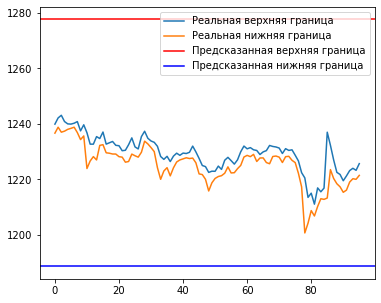

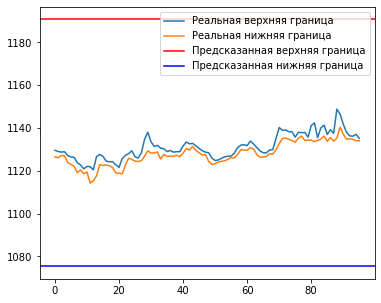

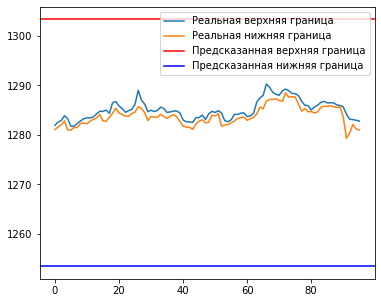

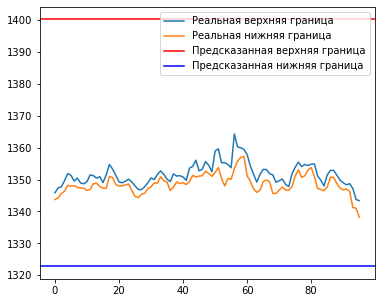

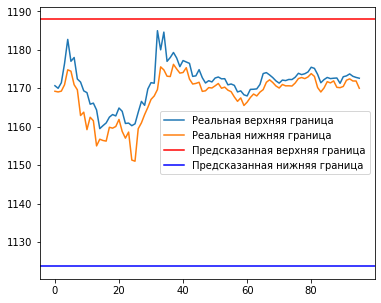

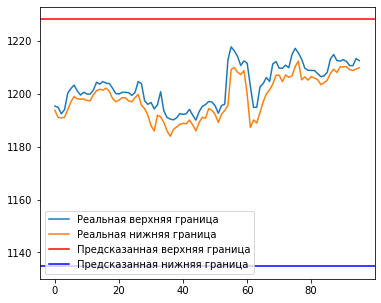

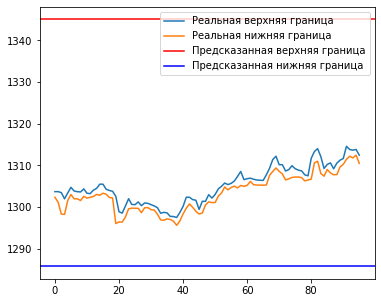

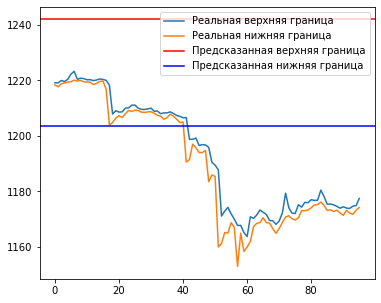

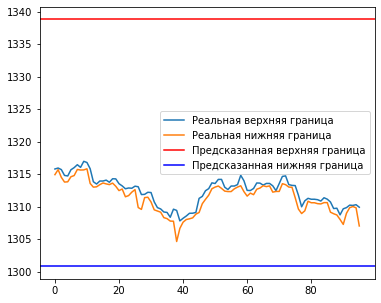

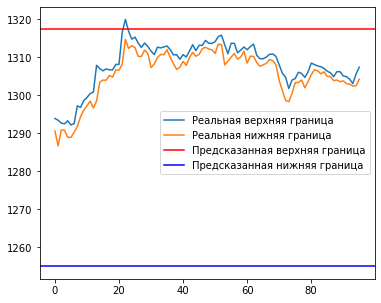

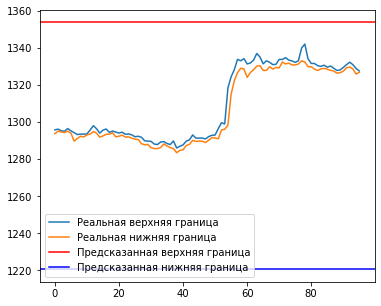

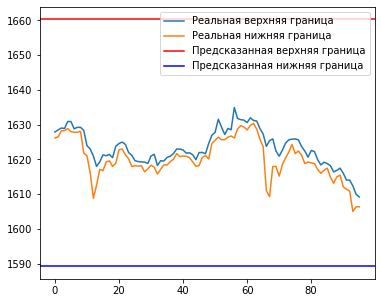

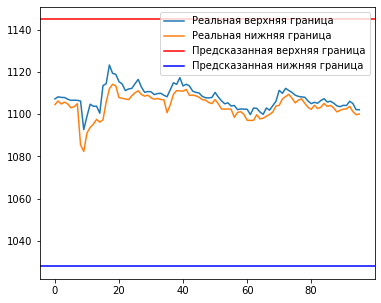

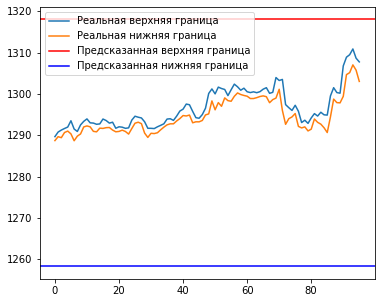

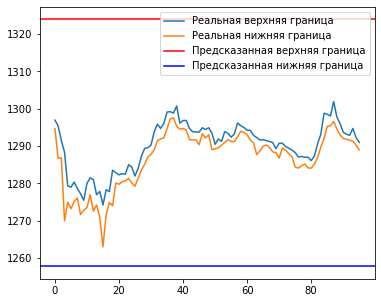

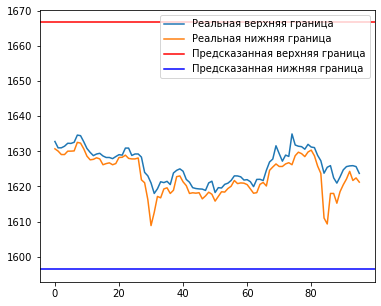

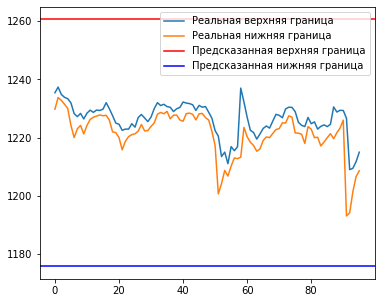

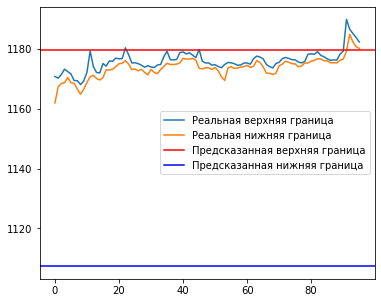

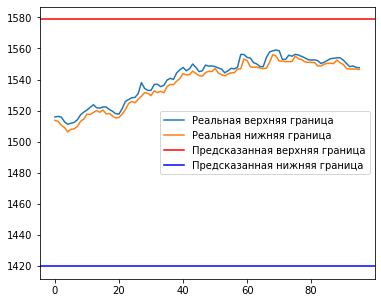

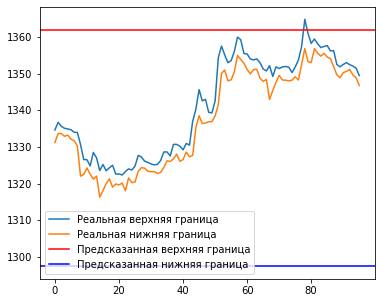

In [23]:
plot_n_random(20, intervals)

### Получение прогнозов в реальном времени

In [26]:
from datetime import datetime, timedelta

#### Функция для подтягивания последних данных

In [27]:
def dataset_for_current_pred(symbol = 'ETHUSDT'):
  '''Функция возвращает последние доступные данные'''
  api_key = ""
  api_secret = ""
  client = Client(api_key, api_secret)
  current_date = datetime.now().strftime("%d-%m-%Y")
  yesterday = (datetime.now()+timedelta(days=-1)).strftime("%d/%m/%Y")
  tommorow = (datetime.now()+timedelta(days=+1)).strftime("%d/%m/%Y") 

  fromDate = str(datetime.strptime(yesterday, '%d/%m/%Y'))
  toDate = str(datetime.strptime(tommorow, '%d/%m/%Y'))
  symbol = symbol
  interval = Client.KLINE_INTERVAL_1MINUTE
  # посколько реализована подгрузка начиная со вчерашнего дня, разумно обрезать датасет 24 часами 24*60=1440
  df = GetHistoricalData(symbol, interval, fromDate, toDate)[-1440:] 
  return df

### Ячейки которые требуется запускать для получения прогноза: 

In [28]:
#Получаем данные
df_current = dataset_for_current_pred()
# Добавляем новую колонку
df_current = make_new_col(df_current)
# требуется для абсолютных значений запомнить текущую
current_value = df_current['open'].values.astype(float)[-1]
# Рассчитываем сам интервал
res_interval = bootstrap(df_current['change'].values, n_forcast=8, intervals_in_hour=60)*current_value

/var/folders/hd/6964l85j4gx1hgy42r98qngc0000gp/T/ipykernel_8738/1757968330.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "bootstrap" failed type inference due to: No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(array(float64, 1d, C))
 
There are 4 candidate implementations:
  - Of which 4 did not match due to:
  Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
    With argument(s): '(array(float64, 1d, C))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic stub>) found for signature:
    
    >>> stub(array(float64, 1d, C))
    
   There are 2 candidate implementations:
     - Of which 2 did not match due to:
     Intrinsic in function 'stub': File: numba/core/overload_glue

In [29]:
res_interval

array([1250.91681717, 1181.80372695])

Полученный интервал выглядит разумно

In [29]:
r = (res_interval[0]/res_interval[1])**1/2

In [30]:
H = (r **1/2 -1)/(r-1)

In [31]:
H

1.5680202747701268